In [1]:
import numpy as np
import torch
import scipy as sp

In [2]:
import scipy
scipy.__version__

'1.9.1'

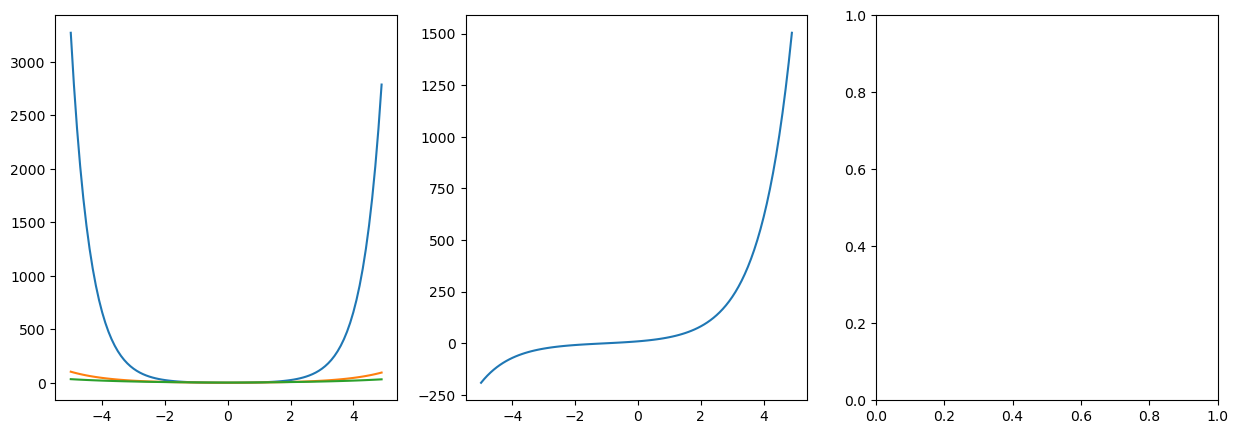

In [3]:
from scipy.special import log_expit, expit

def int_f(ff, dx=0.01):
    x=np.arange(-10, 10, dx)
    y = ff(x)
    return np.trapz(y, x=x)

m0=0.4
q0=0.4
m1=0.5
q1=0.5
m2=0.6
q2=0.7
beta=4
def real_0(h, m0=m0, q0=q0, beta=beta):
    def ff(x):
        return np.exp(-((x)**2)/q0) * np.power(np.cosh(beta*(x+h)),m0)
    return int_f(ff)

def real_1(h, m1=m1, q1=q1, m0=m0, q0=q0, beta=beta):
    def ff(x):
        return np.exp(-((x)**2)/q1) * np.power(real_0(x+h,m0=m0, q0=q0, beta=beta) ,m1)
    return int_f(ff)

def real_2(h, m1=m1, q1=q1, m0=m0, q0=q0, beta=beta,  m2=m2, q2=q2):
    def ff(x):
        return np.exp(-((x)**2)/q2) * np.power(real_1(x+h,m1=m1, q1=q1,m0=m0, q0=q0, beta=beta) ,m2)
    return int_f(ff)

def lot_of_cosh(x, a0=1, b0=1, a1=0, b1=0, a2=0, b2=0, c0=0, c1=0, c2=0., d0=0):
    return a0*np.cosh(b0*x+c0) + a1*np.cosh(b1*x+c1) + a2*np.cosh(b2*x+c2) + d0

import matplotlib.pyplot as plt
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))

hs = np.arange(-5, 5, 0.1)
y=[real_0(h) for h in hs]
y1=[real_1(h) for h in hs]
y2=[real_2(h) for h in hs]
y3=[lot_of_cosh(h, b1=-1, a1=-1.1, c0=1, c1=1, a2=1, b2=-1, c2=-3) for h in hs]
ax1.plot(hs, y)
ax1.plot(hs, y1)
ax1.plot(hs, y2)
ax2.plot(hs, y3)


In [4]:

def f_cos(h, q0=1, beta=1):
    def f_(x, b=0.1):
        return np.exp(-((x)**2)/q0) * np.cos(beta*(x+h)) + b
    return f_

def f_cos_mon(h, q0=6, beta=5):
    def f_(x):
        return h + q0 * np.cos(beta*(x+h))
    return f_

def f_rs(h, q0=1, beta=1):
    def f_(x):
        return np.exp(-((x)**2)/q0) * log_expit(beta*(x+h))
    return f_
def f_rs_approx(x, a, b, c,d):
    return a + b * log_expit(c*x+d)
    
def f_1rsb_0(h, q1=1, m1=0.5, m1_=1, beta=1):
    def f_(x):
        return np.exp(-((x)**2)/q1 + m1_*x + m1*log_expit(beta*(x+h)))
    return f_
def f_1rsb_0_approx(x, a, b, c, d, e):
    return a + np.exp(b + c * log_expit(d*x+e))

def f_1rsb_1(h, q0=1, a=1, b=1, c=1, d=1):
    def f_(x):
        return np.exp(-((x)**2)/q0) * log_expit(a + b * log_expit(c*(x+h) + d))
    return f_
def f_1rsb_1_approx(x, a1, b1, a2, b2, a3, b3):
    return a1 + b1 * log_expit(a2 + b2 * log_expit( a3 + b3 * x))

def f_2rsb_0(h, q0=1, a=1, b=1, c=1, d=1, e=1 ,f=1):
    def f_(x):
        return np.exp(-((x)**2)/q0) * log_expit(f + e*log_expit(a + b * log_expit(c*(x+h) + d)))
    return f_
def f_2rsb_0_approx(x, a0, b0, a1, b1, a2, b2, a3, b3):
    return a0 + b0 * log_expit(a1 + b1 * log_expit(a2 + b2 * log_expit( a3 + b3 * x)))

def f_2rsb_0_approx_serial(x, a0, b0, a1, b1, a2, b2, a3, b3):
    return a0 + b0 * log_expit(a1 + b1 * log_expit( a2 * x)) + b2 * log_expit( a3 + b3 * x)

def f_2rsb_1_approx_serial(x, a0, b0, a1, b1,a11, b11, a2,a22, b2, a3, b3):
    return a0 + b0 * log_expit(a1 + b1 * log_expit( a2 * x)) + b2 * log_expit(a11 + b11 * log_expit( a22 * x))


In [5]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def fit(true_func, fit_func, params_true, range=5, dx=0.1):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
    x = np.arange(-range,range,dx)
    y=[]
    for b in x:
        y.append(int_f(true_func(b, *params_true)))
    popt, pcov = curve_fit(fit_func, x, y, maxfev = 1000000)
    #plt.plot(x, 1.7*np.log(np.cosh(x))+0.4)
    ax1.plot(x, fit_func(x, *popt), 'r-',
            label=f'fit: {popt}')
    ax1.plot(x, y, 'b.',
            label=f'real')
    #ax2.set_ylim(0,2)
    ax2.plot(x, np.abs(fit_func(x, *popt)- y),
            label='diff')
    ax3.plot(x, np.abs(fit_func(x, *popt)- y)/y,
            label='diff')
    ax1.legend()
    for pp in popt:
        print(f"param {pp:.2}")

def plot_curve(true_func, params_true, range=5, dx=0.1):
    fig, ax1 = plt.subplots(1, 1, figsize=(8,5))
    x = np.arange(-range,range,dx)
    y=[]
    for b in x:
        y.append(int_f(true_func(b, *params_true)))
    #plt.plot(x, 1.7*np.log(np.cosh(x))+0.4)
    ax1.plot(x, y, 'b.',
            label=f'real')
def plot_fit(fit_funct, params, range=5, dx=0.1):
    fig, ax1 = plt.subplots(1, 1, figsize=(8,5))
    x = np.arange(-range,range,dx)
    y=[]
    for b in x:
        y.append(fit_funct(b, *params))
    #plt.plot(x, 1.7*np.log(np.cosh(x))+0.4)
    ax1.plot(x, y, 'b.',
            label=f'fit_func')




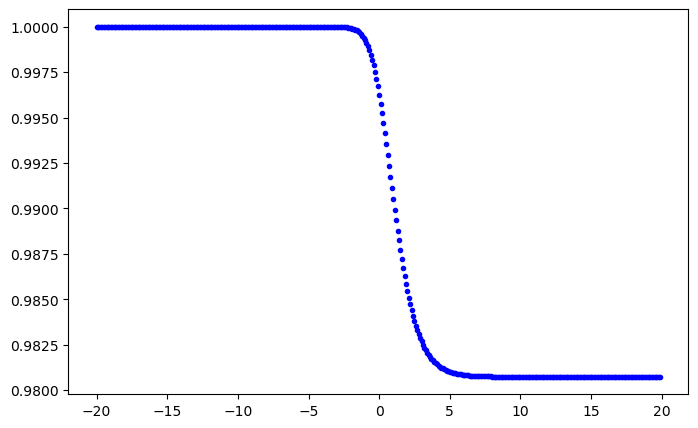

In [6]:
def f_2rsb_0_approx(x, a0, b0, a1, b1, a2, b2, a3, b3):
    return a0 + b0 * log_expit(a1 + b1 * log_expit(a2 + b2 * log_expit( a3 + b3 * x)))

plot_fit(f_2rsb_0_approx,[1, 1, 3, -3, 1, 1, -1, 1], range=20, dx=0.1 )

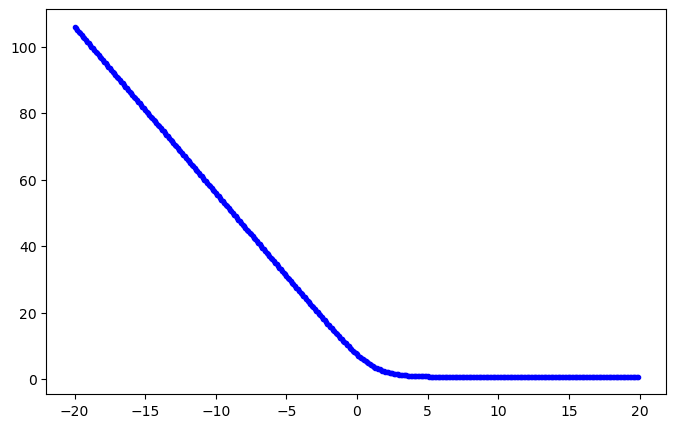

In [7]:

plot_fit(f_2rsb_0_approx_serial,[1, 1, 1, -1, 2, -5, -1, 1], range=20, dx=0.1 )

param 3.1
param 0.044
param 3.1
param 0.044
param 3.1
param 0.044
param 4.6
param 4.6
param 4.6
param -4.6e+02


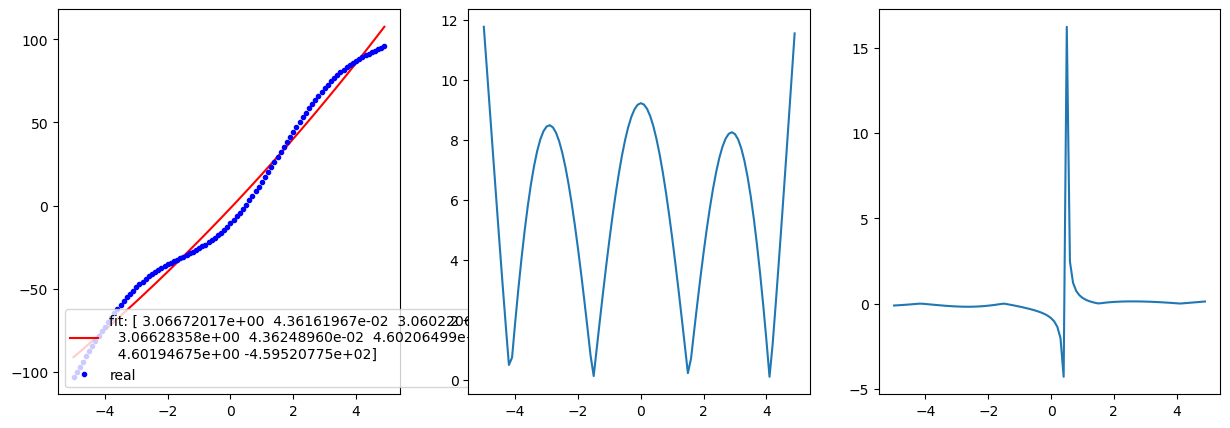

In [8]:
fit(f_cos_mon, lot_of_cosh, [10,1])

param 5.7e+03
param 4e+02
param 2.7e+01
param 4.9e+01
param 2.7e+01
param 4.9e+01
param 0.001
param 0.001
param 4e+02
param 1.0
param 1.0


/Users/ocadni/opt/anaconda3/envs/m1torch/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


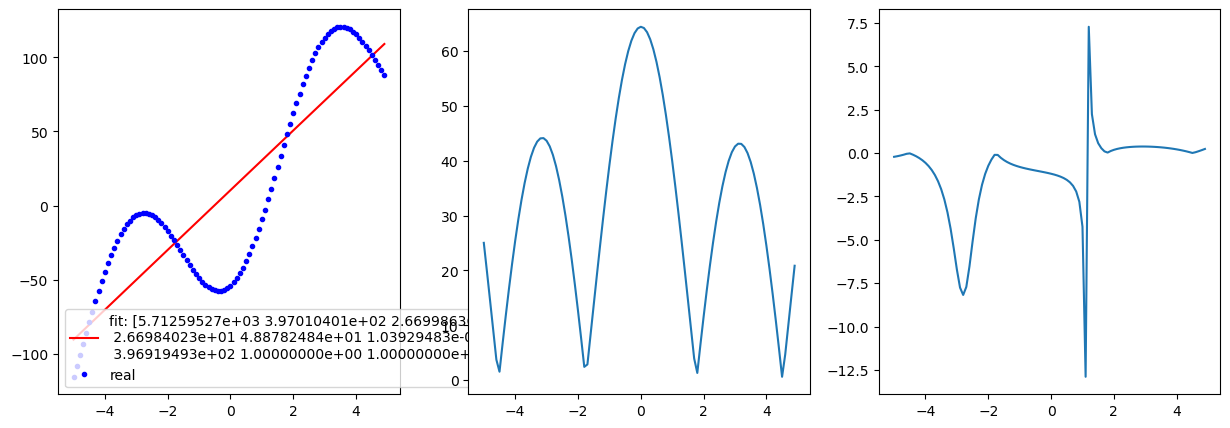

In [9]:
fit(f_cos_mon, f_2rsb_1_approx_serial, [50,1])

param -0.0026
param 0.35
param 1.0
param 1.7
param 0.44


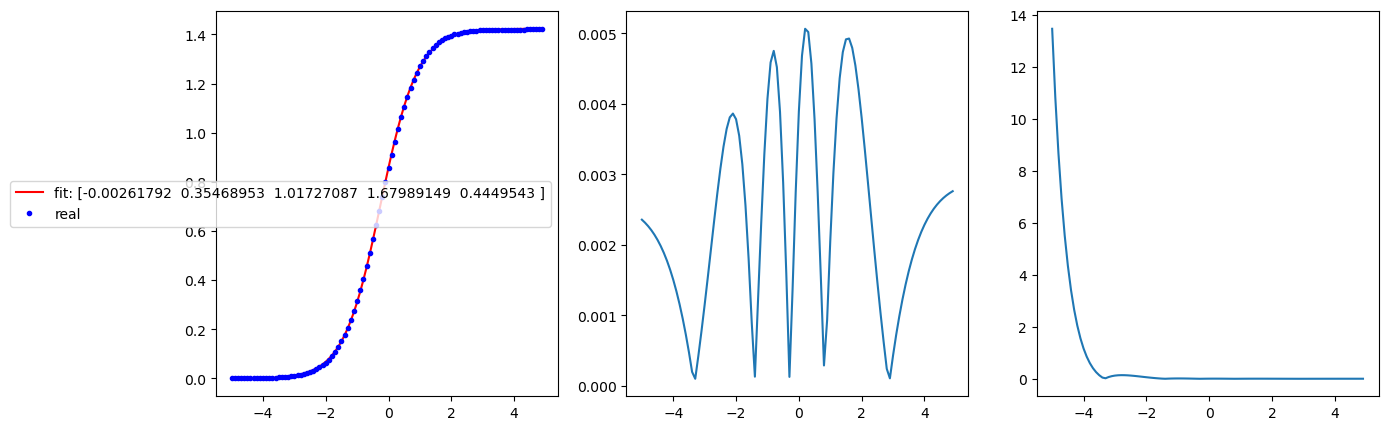

In [ ]:
fit(f_1rsb_0, f_1rsb_0_approx, [0.5,1,1,2])

param -0.0024
param 0.0083
param 4.3e+01
param 5.8
param -3.2e+01
param -7.6


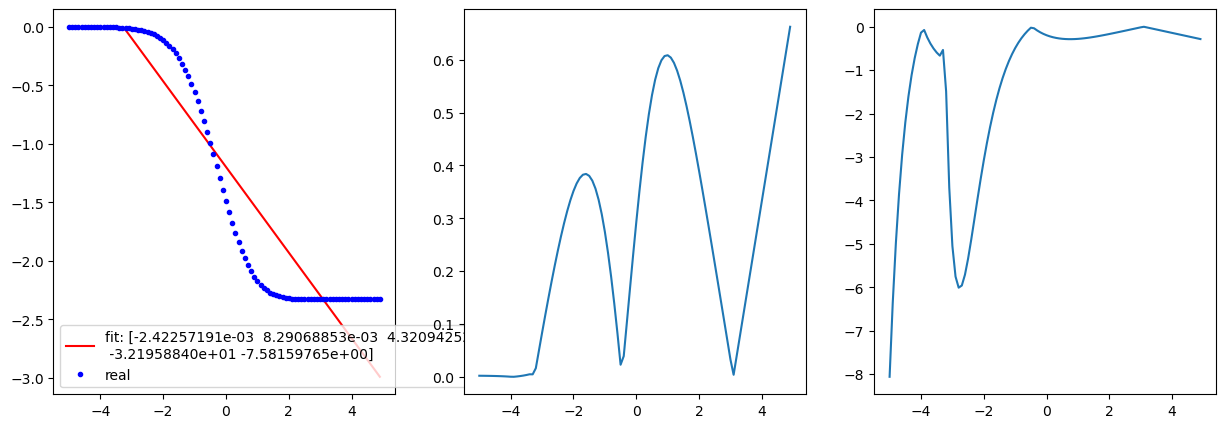

In [ ]:
fit(f_1rsb_1, f_1rsb_1_approx, [1, -1, -0.4, 5.2, -1.2])

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 100000.

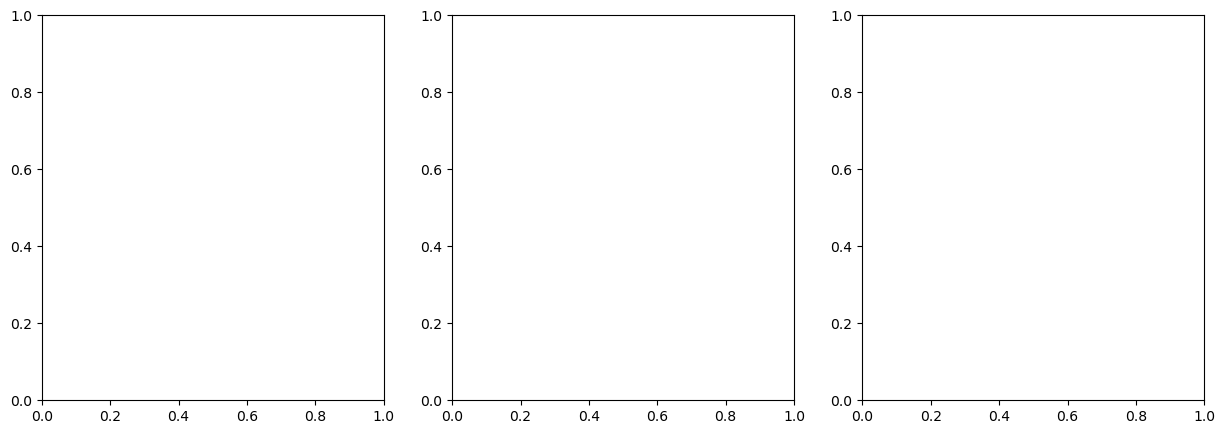

In [70]:
fit(f_2rsb_0, f_2rsb_0_approx, [1, -1, -1.4, -.1, -1, -0.3, -1])

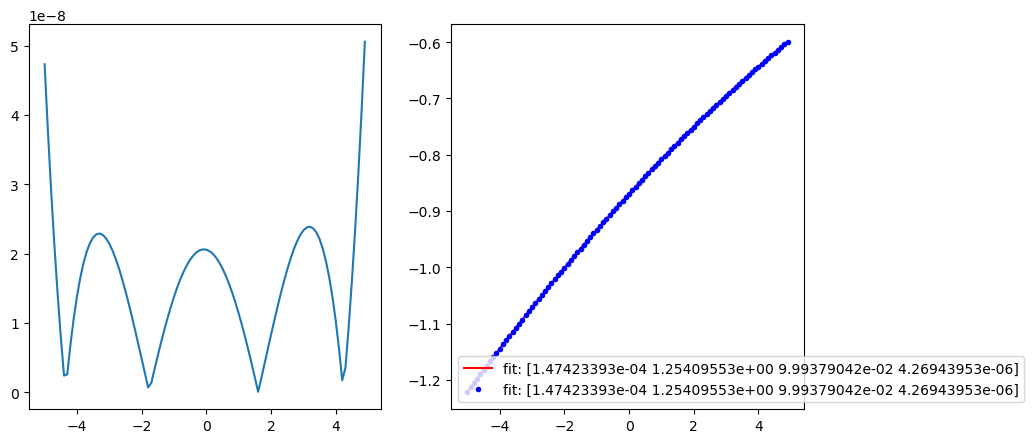

In [27]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

x = np.arange(-5,5,0.1)
true_func = f_rs
fit_func = f_rs_approx
y = []
params_true = [0.5,0.1]
for b in x:
    y.append(int_f(true_func(b, *params_true)))

popt, pcov = curve_fit(fit_func, x, y, maxfev = 100000, ftol=1e-12, xtol=1e-12, gtol=1e-12)
#plt.plot(x, 1.7*np.log(np.cosh(x))+0.4)
ax2.plot(x, fit_func(x, *popt), 'r-',
         label=f'fit: {popt}')
ax2.plot(x, y, 'b.',
         label=f'fit: {popt}')
#ax2.set_ylim(0,2)
ax1.plot(x, np.abs(fit_func(x, *popt)- y),
         label='diff')
plt.legend()

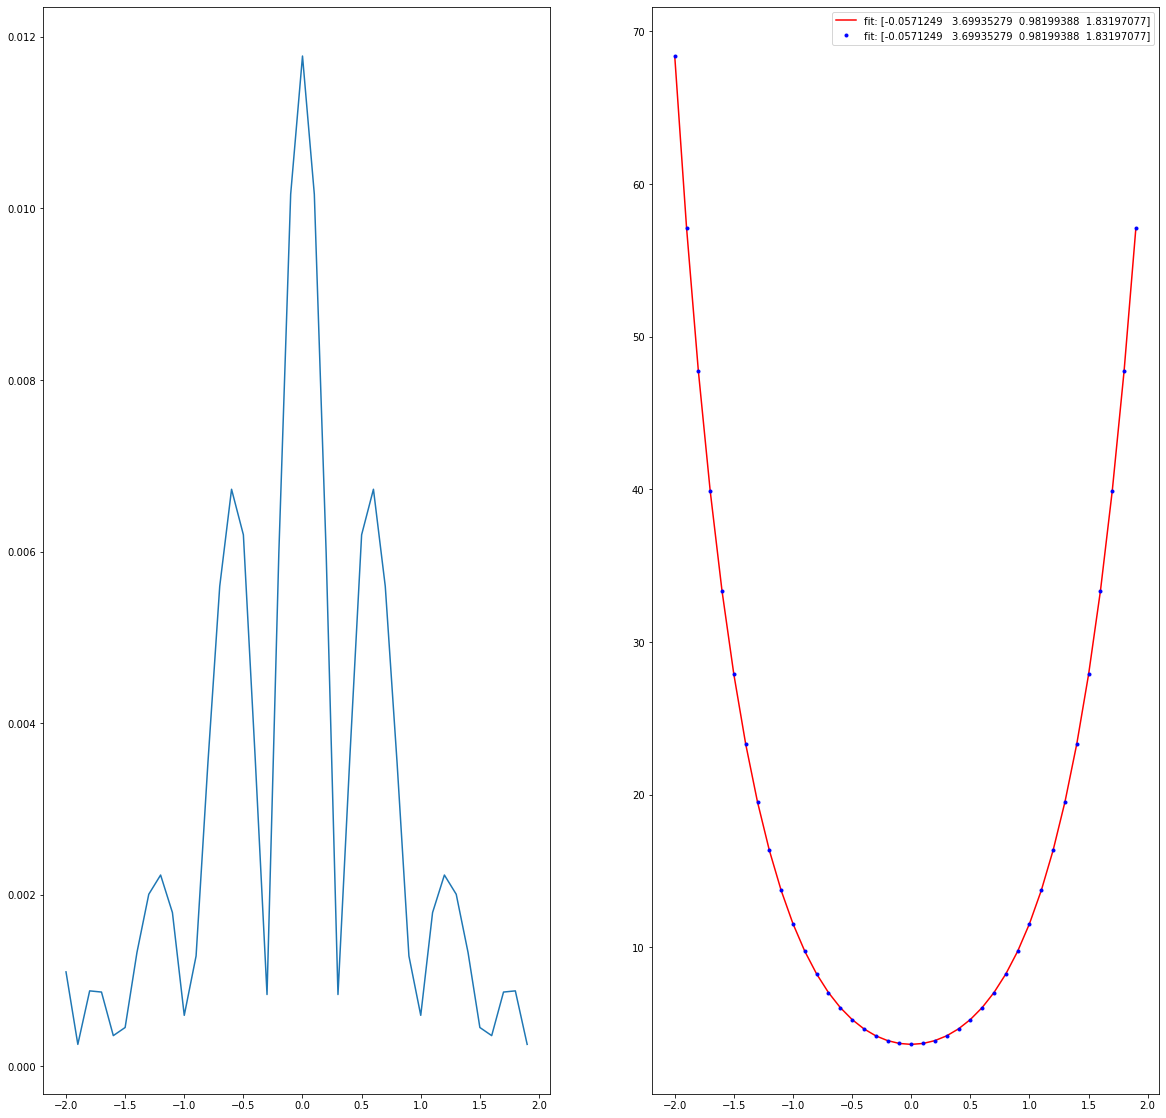

In [162]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,20))

x = np.arange(-2,2,0.1)
true_func = f_1rsb_0
fit_func = f_1rsb_0_approx
y = []
params_true = [0.9,0.9,2]
for b in x:
    y.append(int_f(true_func(b, *params_true)))

popt, pcov = curve_fit(fit_func, x, y, maxfev = 100000)
#plt.plot(x, 1.7*np.log(np.cosh(x))+0.4)
ax2.plot(x, fit_func(x, *popt), 'r-',
         label=f'fit: {popt}')
ax2.plot(x, y, 'b.',
         label=f'fit: {popt}')
#ax2.set_ylim(0,2)
ax1.plot(x, 100*np.abs(fit_func(x, *popt)- y)/y,
         label='diff')
plt.legend()

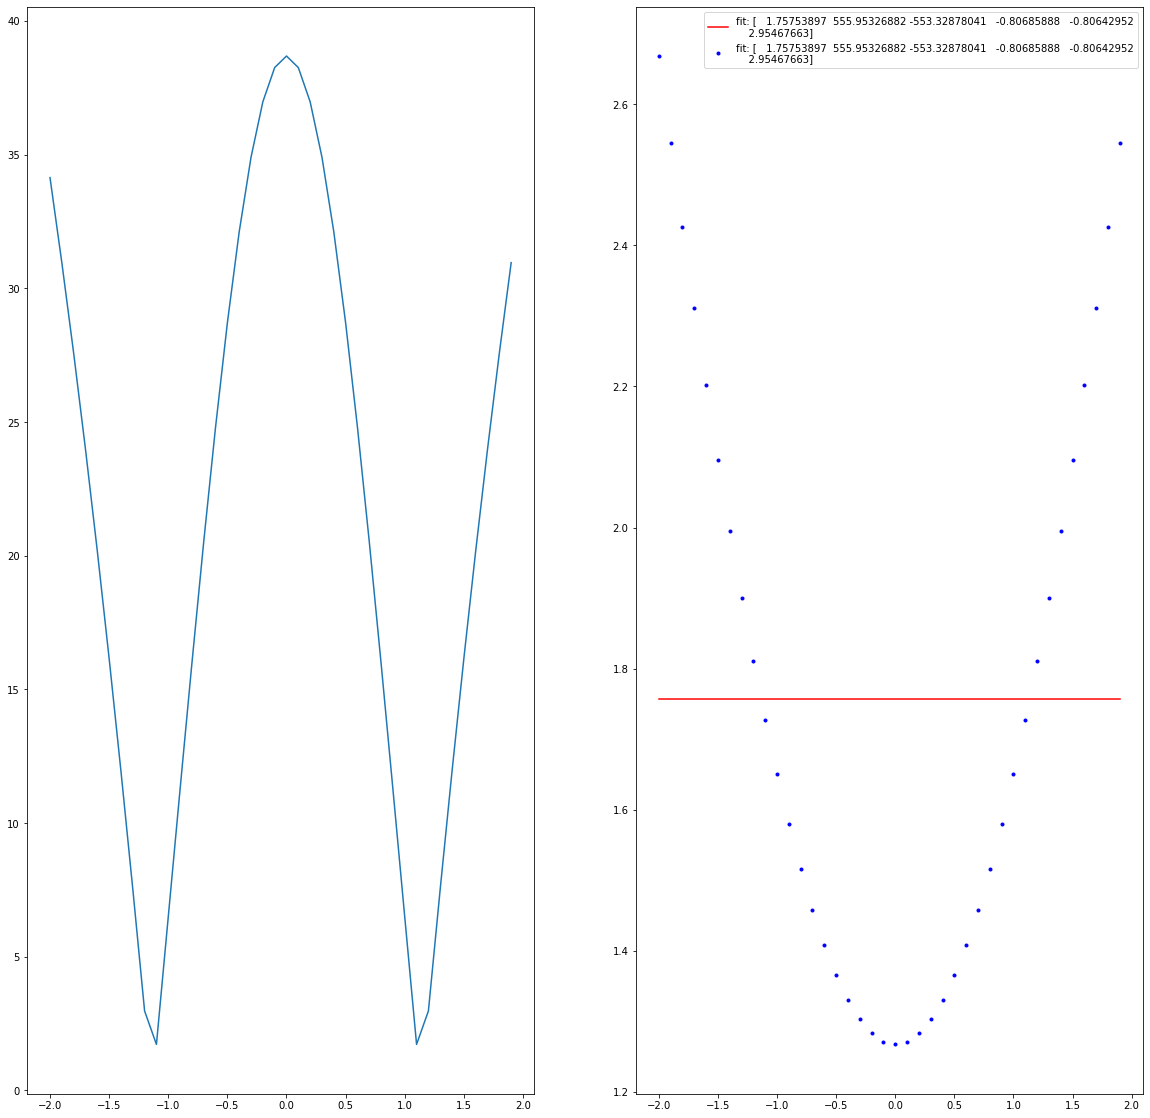

In [164]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,20))

x = np.arange(-2,2,0.1)
true_func = f_1rsb_1
fit_func = f_1rsb_1_approx
y = []
params_true = [0.9,0.9,1,1]
for b in x:
    y.append(int_f(true_func(b, *params_true)))

popt, pcov = curve_fit(fit_func, x, y, maxfev = 100000)
#plt.plot(x, 1.7*np.log(np.cosh(x))+0.4)
ax2.plot(x, fit_func(x, *popt), 'r-',
         label=f'fit: {popt}')
ax2.plot(x, y, 'b.',
         label=f'fit: {popt}')
#ax2.set_ylim(0,2)
ax1.plot(x, 100*np.abs(fit_func(x, *popt)- y)/y,
         label='diff')
plt.legend()

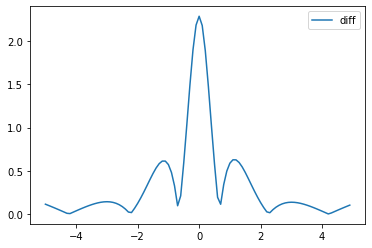

In [123]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def func(x, a, b, c, d):
    return a * np.log(np.cosh(d*x+c)) + b

x = np.arange(-5,5,0.1)
y = []
h0=0
a=1
for b in x:
    y.append(int_f(f(b, h0, a)))

#plt.plot(x,y)
xx=np.arange(-1,1,0.01)
yy=0.65*xx**2+0.4
#plt.plot(xx,yy)
xxx=np.arange(1,5,0.01)
yyy=1.8*xxx-1
#plt.plot(xxx,yyy)
x2=np.arange(-5,5,0.01)
popt, pcov = curve_fit(func, x, y)
#plt.plot(x, 1.7*np.log(np.cosh(x))+0.4)
#plt.plot(x, func(x, *popt), 'r-',
#         label='fit: a=%5.3f, b=%5.3f, c=%5.3f,d=%5.3f,' % tuple(popt))
plt.plot(x, 100*np.abs(func(x, *popt)- y)/y,
         label='diff')
plt.legend()

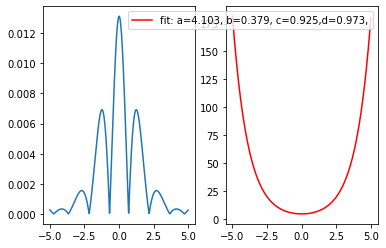

In [99]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

fig, (ax1, ax2) = plt.subplots(1, 2)

def func_m(x, a, b, c, d):
    return (a * np.cosh(c*x) + b)**d

x = np.arange(-5,5,0.01)
y = []
h0=0
a=2
m=0.9
c=0.2
for b in x:
    y.append(int_f(f_m(b, h0=h0, a=a, m=m, c=c), dx=0.01))

#plt.plot(x,y)
popt, pcov = curve_fit(func_m, x, y, maxfev = 100000, p0=[1,0.1,1,m])
#plt.plot(x, 1.7*np.log(np.cosh(x))+0.4)
ax2.plot(x, func_m(x, *popt), 'r-',
         label='fit: a=%5.3f, b=%5.3f, c=%5.3f,d=%5.3f,' % tuple(popt))
ax1.plot(x, 100*np.abs(func_m(x, *popt)- y)/y,
         label='diff')
plt.legend()

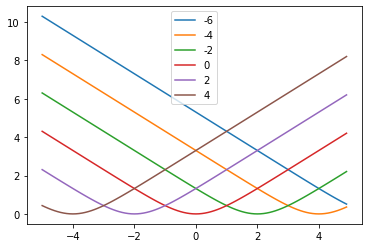

In [66]:
bb = np.arange(-6,6,2)
y = []
for b in bb:
    x = np.arange(-5,5,0.1)
    y = f1(b,x)
    plt.plot(x,y, label=f"{b}")
plt.legend()
